# Simulating human speech adaptation with fast weight neural network 

This project is a study of Charles Wu's PhD dissertation, which investigates the neural mechanisms of speech adaptation. Specifically, we try to simulate an acoustically-driven adaptation phenomenon called Dimension-based statistical learning (an empirical study can be found [here](https://www.cmu.edu/dietrich/psychology/holtlab/PDF/lori.%20MY%20Papers/IdemaruHolt2011.pdf)). 

This project is a specific implementation of the supervised error-driven learning idea proposed by [Guediche et al, 2016](https://www.cmu.edu/dietrich/psychology/holtlab/PDF/lori.%20MY%20Papers/GuedicheEtAl_CerebralCortex_2014.pdf) we conceptualize the humans achieve speech adaptation by having two separate pathways in the system: one learns slowly but stores long-term representations of how acoustic input can map to linguistic representations; another one learns very quickly and can constantly make dynamic adjustments and adaptation in real-time. Specifically, we hypothesize that long-term representations learned through the "slow" pathway (akin to category learning through interactions between cortical and subcortical structures [ref](https://www.cmu.edu/dietrich/psychology/holtlab/PDF/lori.%20MY%20Papers/limfiezholt2019.pdf) can be used to guide or supervise on-line speech adaptation in the fast pathway (see this [paper](http://www.cnbc.cmu.edu/~plaut/papers/pdf/HintonPlaut87CogSciConf.fastWeights.pdf)). 

This is a collaboration with a team of statistics/machine learning undergraduate seniors at Carnegie Mellon: Madhuri Raman, Annie Hu, David Xu and June Cha.

For the following document, I will use 'b' and 'p' categories as an example. Although this simulation is agnostic about acoustic dimensions and phonetic categories--simulation results should be general to all dimensions and categories. Throughout the document, primary dimension is always dimension 1 and secondary dimension is dimension 2.

The neural network will have 3 phases:1.Pre-training(and pilot-testing) 2.Exposure 3.Test. We start with the pre-training phase by harnessing the network with some initial representations of categorizing the 'b' and 'p' sounds. 

## 1. Pre-training and input data
To begin with, we will generate simulated data as model input. 

In order not to overload the term 'dimension', it will only refer to acoustic dimension in this document. For data dimensions, I will use 'size' instead.  

Dimention 1 and dimension 2 will carve out the same space (multivariate gaussians centered on the same value but different variances) for each category with different variances: sigma_1 = 0.13, sigma_2 = 0.13 \* 2. For 'b' sounds, dimension values will be drawn from a multivariate normal with mu = [0.25, 0.8] and the **range = [0, 0.5]**. For the 'p' sounds, values will be drawn from a separate truncated normal distribution with mu = [0.75, 0.8], and **range = [0.5, 1]** .

For each acoustic dimension in the input data, we will first randomly generate 1000 gaussian numbers (level 1). Then, each of these is a training data that the input units will represent. For each of these values, we will generate a separate gaussian centered on this value and get the density for 15 linearly interpolated x values (level 2). That is, for each acoustic dimension, for each sound category (such as 'b'), one training data point will have size 1\*15. We concatenate this with the second category (such as 'p'), which is also  1\*15. So for each training data, we have a size of 1 \* 30. This brings out size of the training data for each acoustic dimension to **1000 \* 30**. 


We start by defining the key parameters for the input data

In [355]:
import numpy as np
import pickle as pkl
import datetime as dt
import matplotlib.pyplot as plt

###Let's start out by defining some key parameters

## Level 1 parameters
##Note that the range of dimension values is the same for dimension 1 and dimension 2, but different for the two categories
##On the contrary, variances are different for the two dimensions (by a factor of 2), but same for the two categories.

## Dimension 1 means and variances

mu_b = 0.25
mu_p = 0.75

var_scale = 2

sigma_1 = 0.13
sigma_2 = sigma_1*var_scale

## Level 2 parameters
sigma_sub = 0.04
input_size = 15

##Other parameters
n = 1000
left = 0
boundary = 0.5
right = 1
random = 1234

We will draw values for the level 1. Each value is a training data point that we want the input units to represent.

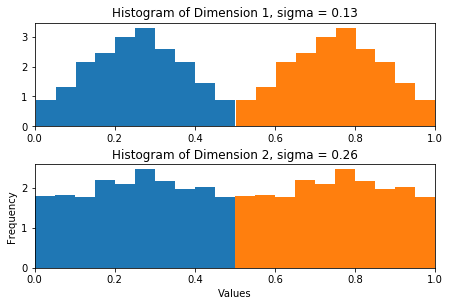

In [358]:
###For Dimension 1, we first generate 1000 random numbers from a truncated normal distribution 
###with miu = 0.25, sigma = 0.13, clipped from [0, 0.5] and [0.5,1]
###Every one of the 1000 numbers represents an instance of the dimension value in the training data. 

###Dimension 1 for the 'b' sounds
###First convert the boundaries to z-scores. use random seed to ensure reproducibility
b_left_1 = (left - mu_b)/sigma_1
b_right_1 = (boundary - mu_b)/sigma_1
b_input_1 = truncnorm.rvs(b_left_1,b_right_1,loc=mu_b, scale=sigma_1, size = n, random_state=random)

###Dimension 1 for the 'p' sounds
p_left_1 = (boundary - mu_p)/sigma_1
p_right_1 = (right - mu_p)/sigma_1
p_input_1 = truncnorm.rvs(p_left_1,p_right_1,loc=mu_p, scale=sigma_1, size = n, random_state=random)

###Dimension 2 for the 'b' sounds
b_left_2 = (left - mu_b)/sigma_2
b_right_2 = (boundary - mu_b)/sigma_2
b_input_2 = truncnorm.rvs(b_left_2,b_right_2,loc=mu_b, scale=sigma_2, size = n, random_state=random)

###Dimension 2 for the 'p' sounds
p_left_2 = (boundary - mu_p)/sigma_2
p_right_2 = (right - mu_p)/sigma_2
p_input_2 = truncnorm.rvs(p_left_2,p_right_2,loc=mu_p, scale=sigma_2, size = n, random_state=random)

###Below is a visualization of all the values we just sampled 
fig, ax = plt.subplots(2,1)
ax[0].hist(b_input_1, density = True)
ax[0].hist(p_input_1, density = True)
ax[0].set_title('Histogram of Dimension 1, sigma = %s'%(sigma_1))
ax[0].set_xlim((0,1))

ax[1].hist(b_input_2, density = True)
ax[1].hist(p_input_2, density = True)
ax[1].set_title('Histogram of Dimension 2, sigma = %s'%(sigma_2))
ax[1].set_xlim((0,1))
#plt.plot(x_b_1, truncnorm.pdf(x_b_1,0,0.5,loc=mu_b, scale=sigma_1),'r-', lw=5, alpha=0.6, label='norm pdf')
fig.tight_layout(pad = 0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Next, we will actually get the values for our input data (level 2). We do this by obtaining the density for 10 linearly interpolated x-values from a separate truncated normal centered around the value (out of 1000 drawn above) to be represented. The data shape should be 1000\*2\*15). The input values for the two dimensions are currently stacked into to two rows. They can be concatenated later if needed. 

In [361]:
level_1 = {'b_input_1':b_input_1,
       'b_input_2':b_input_2,
       'p_input_1':p_input_1,
       'p_input_2':p_input_2}

input = {'input_b': np.empty([n, 2, input_size]),
         'input_p': np.empty([n, 2, input_size])}

for key in level_1:
    for i in np.arange(100):
        center = level_1[key][i]
        if key[0] == 'b':
            lower = (left - center)/sigma_sub
            upper = (boundary - center)/sigma_sub
            ##get quantiles
            x = np.linspace(truncnorm.ppf(0.00000001, lower, upper, loc=center, scale=sigma_sub),
            truncnorm.ppf(0.99999999, lower, upper, loc=center, scale=sigma_sub), input_size)
            ##get density
            input['input_b'][i,int(key[-1]) - 1] = np.round(truncnorm.pdf(x, lower, upper, loc=center, scale=sigma_sub), decimals = 2)
        else:
            lower = (boundary - center)/sigma_sub
            upper = (right - center)/sigma_sub
            x = np.linspace(truncnorm.ppf(0.00000001, lower, upper, loc=center, scale=sigma_sub),
            truncnorm.ppf(0.99999999, lower, upper, loc=center, scale=sigma_sub), input_size)
            input['input_p'][i,int(key[-1]) - 1] = np.round(truncnorm.pdf(x, lower, upper, loc=center, scale=sigma_sub), decimals = 2)

print(np.shape(input['input_b']))


(1000, 2, 15)


In [364]:
###Take a quick look at a sample data
print('b', input['input_b'][0])
print('p', input['input_p'][0])

b [[0.01 0.13 0.72 2.63 6.2  9.49 9.41 6.04 2.52 0.68 0.12 0.01 0.   0.
  0.  ]
 [0.23 0.98 2.97 6.31 9.37 9.73 7.07 3.6  1.28 0.32 0.06 0.01 0.   0.
  0.  ]]
p [[0.01 0.13 0.72 2.63 6.2  9.49 9.41 6.04 2.52 0.68 0.12 0.01 0.   0.
  0.  ]
 [0.23 0.98 2.97 6.31 9.37 9.73 7.07 3.6  1.28 0.32 0.06 0.01 0.   0.
  0.  ]]
